# **Data Visualisation Notebook**

## Objectives

* Solving Business Requirement 1: "Conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew."

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/validation
* inputs/mildew_dataset/cherry-leaves/test

## Outputs

* Image shape embeddings saved as pickle files
* Plots of image mean and variability per class label
* Plot to distinguish between healthy leaves and leaves infected with powdery mildew
* A randomly generated image montage of the class labels that can be used for the Streamlit dashboard



---

## Import Libraries

In [1]:
import os
from matplotlib.image import imread
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tensorflow.keras.preprocessing import image
import itertools
import random

## Set working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/Users/nathalievonheyl/Documents/ci-code_institute/PP5/pp5_mildew-detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/Users/nathalievonheyl/Documents/ci-code_institute/PP5/pp5_mildew-detection'

## Set Input Directories

Set paths for train, validation and test set

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, "train")
val_path = os.path.join(my_data_dir, "validation")
test_path = os.path.join(my_data_dir, "test")

## Set Output Directories

Check if file path `outputs/{version}` exists. If not: Create a new output directory with updated version number.

In [6]:
version = 'v1'
file_path = os.path.join("outputs", version)

if os.path.exists(file_path):
    print('Old version is already available create a new version.')
else:
    os.makedirs(file_path)

## Set Labels

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


---

## Visualisation of image data

### Image shape

Compute the size of the average image on the train set by measuring the height and width of every image in the dataset. Plot the results as a scatter plot chart. The scatter plot shows whether the images are consistently sized or have a wide variety of dimensions.

This step is completed as a preparation for standardizing input image sizes.

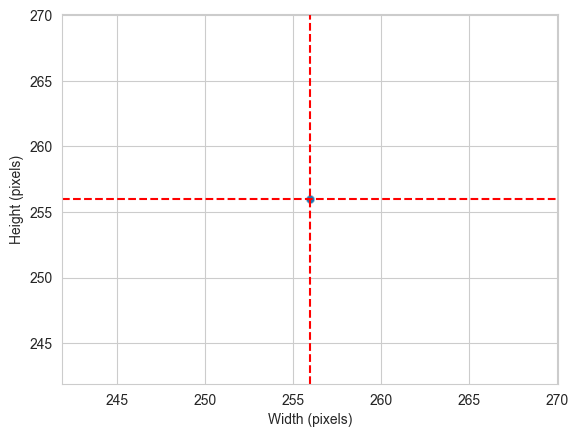

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(os.path.join(train_path, label)):
        img = imread(os.path.join(train_path, label, image_filename))
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

All images already have the same dimensions (256 x 256 pixels), there are no outlier or variations in size. Therefore, no further processing is needed for standardization purposes.

**Save Image Size and Embeddings**

In [9]:
image_shape = (256, 256, 3)
image_shape

(256, 256, 3)

In [10]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

### Average and variability of images per label

Output 2: Define the mean and standard deviation of pixel values in healthy and infected leaf images. 

In order to create the plot to showcase this, the image data needs to be loaded into an array. In the following function the image shape is loaded along with the respective label in an array. 

This step prepares the image data for the training of the ml model.

A module is imported to load (, potentially resize) and convert the image files into numbers (num arrays). This is needed for the computer to be able to process the pictures.

In [11]:
def load_image_as_array(my_data_dir, new_size, n_images_per_label):
    """
    Function to convert images to numerical arrarys for model training.

    Args: 
    * my_data_dir = path to image dataset folder
    * new_size = target image size
    * n_images_per_label = number of images per category
    
    Returns a tuple: x = numpy array of img data, y = numpy array of labels.
    """

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(os.path.join(my_data_dir, label)):
            if counter < n_images_per_label:
                img_path = os.path.join(my_data_dir, label, image_filename)

                img = image.load_img(img_path, target_size=new_size)

                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [12]:
X, y = load_image_as_array(my_data_dir=train_path, new_size=image_shape, n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

Plot the average image to understand what a typical image of this dataset looks like. This helps to identify features and general structure of the image in question. 

The standard deviation within each class label tells about the level of diversity in how the images look. Low variability means that the images are quite similar to each other. High variability means they differ significantly from each other which can be challenging for the model to classify.

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    Function to create plots showing the mean and variablity of images of each class label.
    
    Args:
    * X = numpy array of image data
    * y = numpy array of image labels
    * figsize = size of output plot (width, height)
    * save_image = bool to save plot as image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=125)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


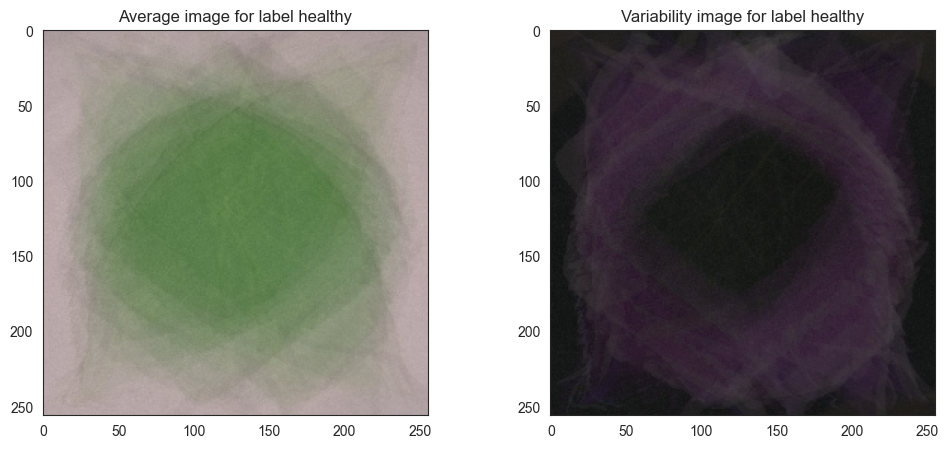

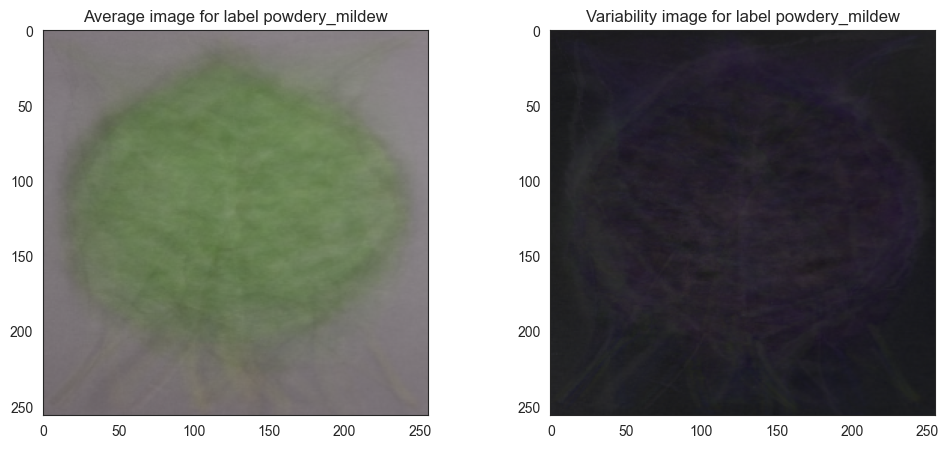

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

### Differentiate average healthy and infected leaves

Create a function to compare the average images of the two class labels. It visualizes how the mean images of the two labels differ in pixel values. By plotting the result it helps analyze visual similarities and differences between the two class label categories.

In [15]:
def subset_image_label(X, y, label_to_display):
    """
    Function to reshape images for comparison and filter based on the label_to_display.

    Args:
    * X = NumPy array of images
    * y = NumPy array of image labels
    * label_to_display = specify label to filter images by

    Returns numpu array containing only images that match the specified label.
    """
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

In [16]:
def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize, save_image=False):
    """
    Function to compare the average images of label_1 and label_2
    by calculating the mean image for each label and visualizing the difference.

    Args:
    * X = NumPy array of images
    * y = NumPy array of image labels
    * label_1 = first label for comparison
    * label_2 = second label for comparison
    * figsize = tuple specifying the figure size
    * save_image = bool flag whether to save img of plot (default: False)

    Returns a comparison of the average images for label_1 and label_2 and their difference.
    Optionally saves the visualization if save_image is set to True.
    """
    sns.set_style("white")

    # check if labels exist in dataset
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label_1} or label {label_2}, are not in"
            f" {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # compute difference and plot results
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')

    # save or show plot
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=125)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13699346706271176..0.3299346418430408].


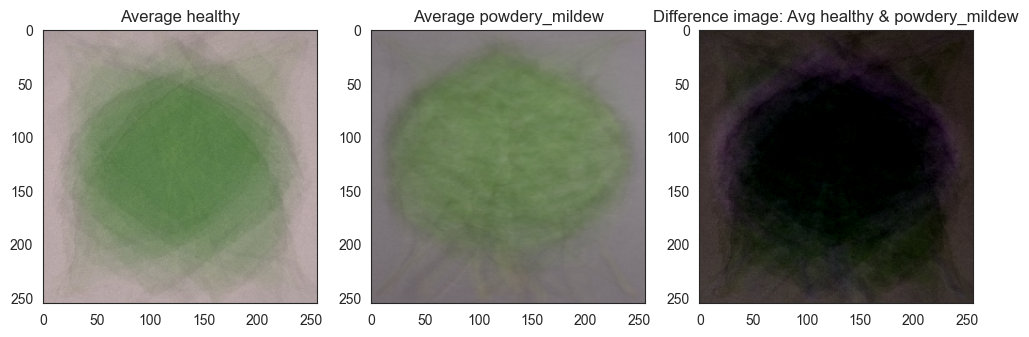

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X,
                                        y=y,
                                        label_1='healthy',
                                        label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

Create a grid of images and store the images in a specified label directory. The displayed images per label are randomly selected and displayed in a subplot grid.

In [18]:
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Function to display a montage of randomly selected images from a label folder.

    Args:
    * dir_path
    * label_to_display
    * nrows
    * ncols
    * figsize

    If label exists and contains enough images, the function selects a random
    subset and arranges the images in a montage grid.
    """
    
    labels = os.listdir(dir_path)
    
    # check if label exists
    if label_to_display in labels:
        images_list = os.listdir(os.path.join(dir_path, label_to_display))

        # checks if enough images in subset for requested images in montage
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Too many montage grid spaces requested. \n"
                f"Only {len(images_list)} images avaiable in subset, "
                f"but {nrows * ncols} spaces requested. Reduce nrows or ncols."
                )
            return

        # create nrows and ncols index pairs to generate grid
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create figure and plot images in montage
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(os.path.join(dir_path, label_to_display, img_idx[x]))
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    
    # handle missing labels
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

powdery_mildew


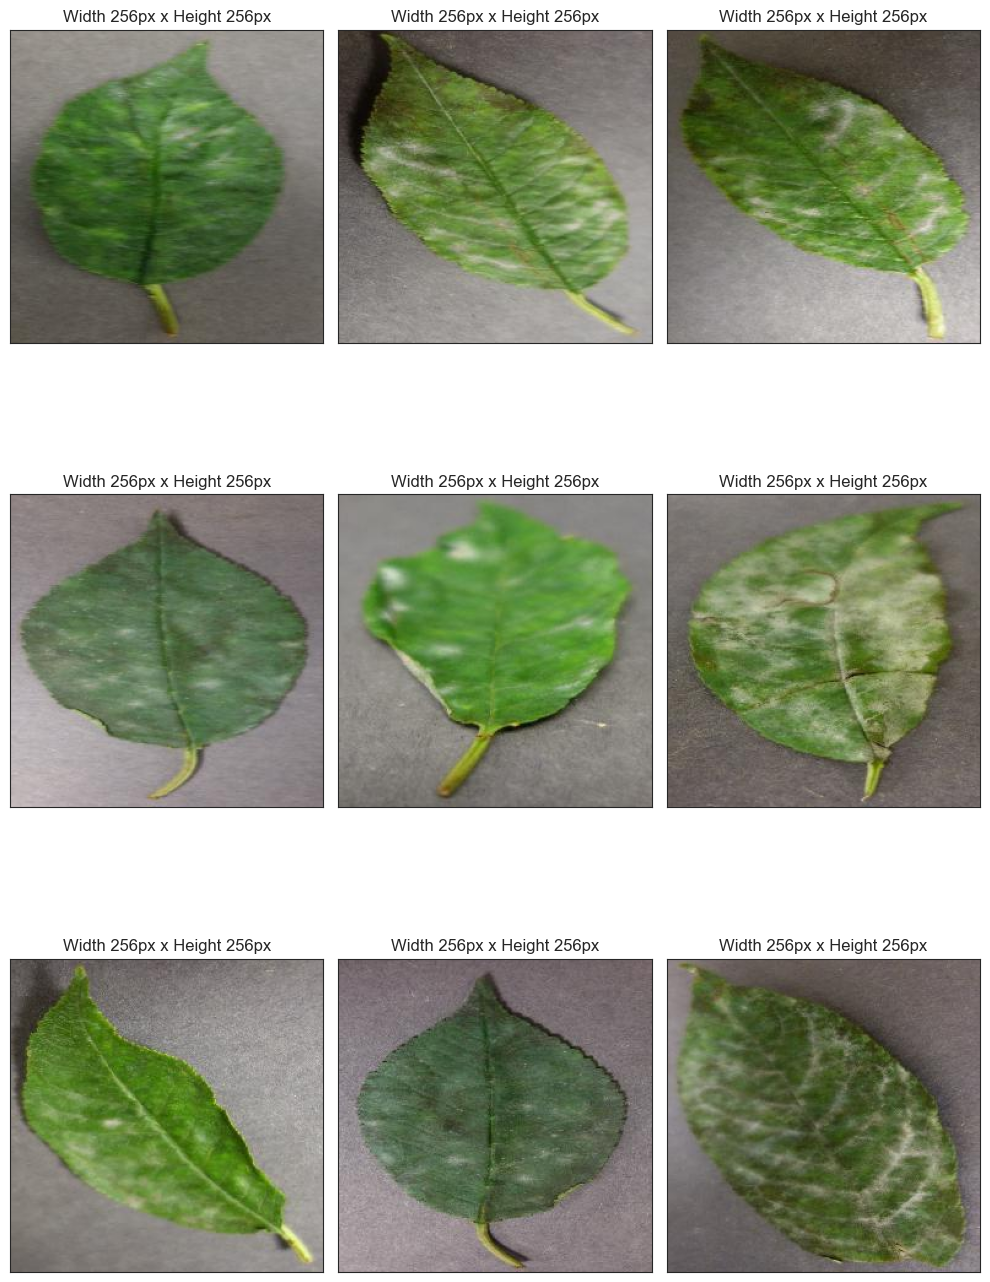



healthy


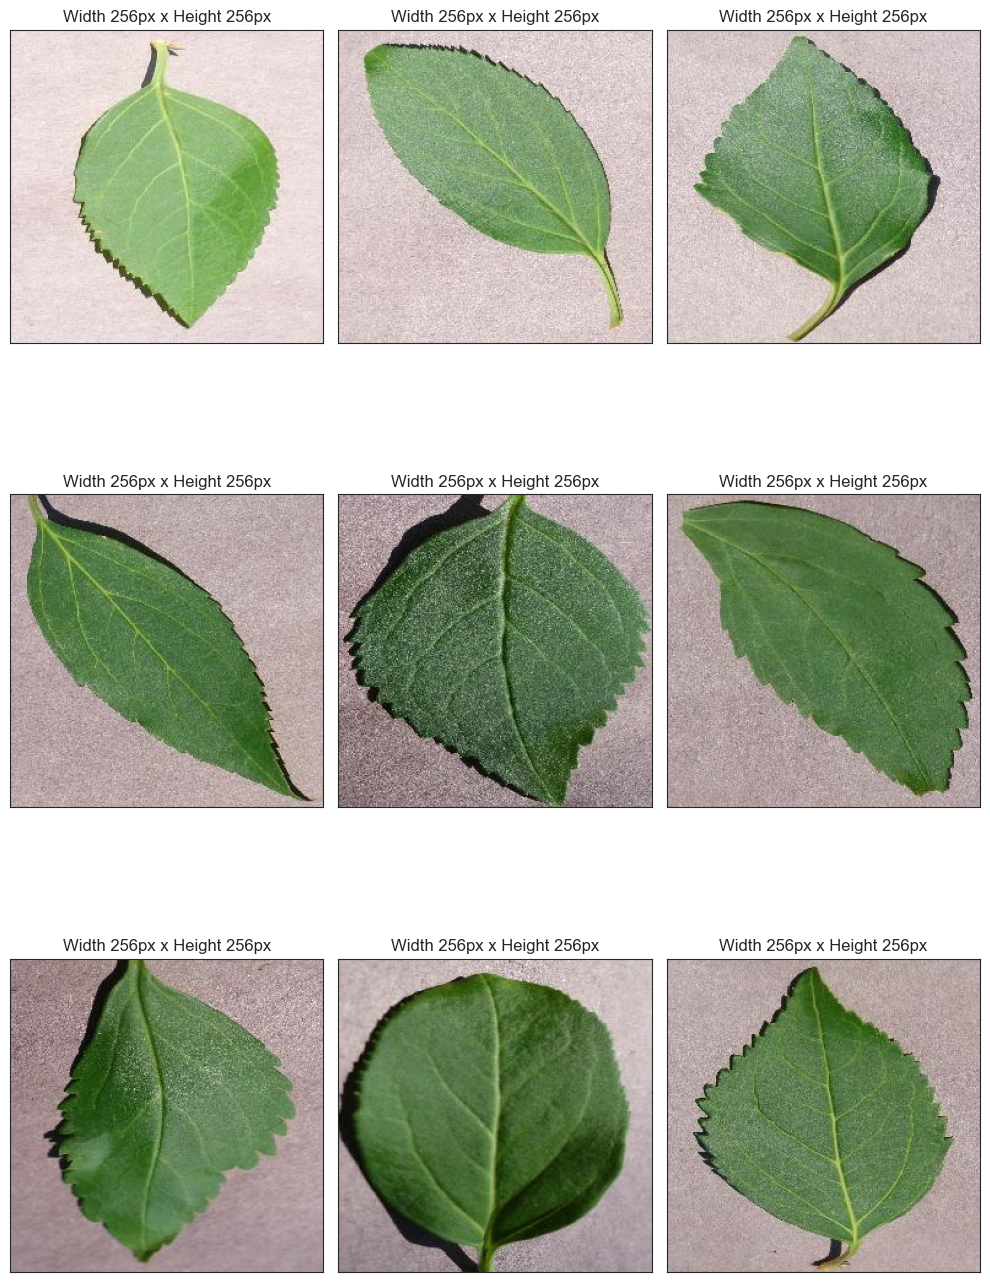

In [19]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

## Conclusion and Next Steps

* Determined image shape and saved embeddings (as a reference for further image processing)
* Examined images to address Business Requirement 1: A visual assessment of the dataset
* Verified that healthy cherry leaves can be clearly distinguished from those affected by powdery mildew